# Analyzing Model Calibration with CalCurve

This notebook demonstrates the usage of CalCurve to analyze model calibration
under different scenarios and settings.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from calcurve import CalibrationCurve

## Generate balanced and imbalanced datasets

In [2]:
# Generate a balanced dataset with 500 test samples (30% split)
n_samples_balanced = 1667  # Will give ~500 test samples with 0.3 test_size
X_balanced, y_balanced = make_classification(
    n_samples=n_samples_balanced,
    n_features=20,
    n_informative=10,
    n_redundant=10,
    class_sep=0.8,
    random_state=42,
    weights=[0.5, 0.5],  # Equal class weights
)

# Generate an imbalanced dataset with exactly 10% positive samples
n_samples_imbalanced = 1667  # Will give ~500 test samples with 0.3 test_size
n_positive = n_samples_imbalanced // 10  # Exactly 10% positive samples
n_negative = n_samples_imbalanced - n_positive

X_imbalanced, y_imbalanced = make_classification(
    n_samples=n_samples_imbalanced,
    n_features=20,
    n_informative=10,
    n_redundant=10,
    class_sep=0.8,
    random_state=42,
    weights=[0.9, 0.1],  # Exactly 10% positive samples
)

# Split datasets
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42
)

X_imbal_train, X_imbal_test, y_imbal_train, y_imbal_test = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.3, random_state=42
)

## Train different models

In [3]:
# Train a logistic regression on balanced data
lr_balanced = LogisticRegression()
lr_balanced.fit(X_balanced_train, y_balanced_train)
lr_balanced_probs = lr_balanced.predict_proba(X_balanced_test)[:, 1]

# Train a random forest on balanced data
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_balanced_train, y_balanced_train)
rf_balanced_probs = rf_balanced.predict_proba(X_balanced_test)[:, 1]

# Train models on imbalanced data
lr_imbal = LogisticRegression()
lr_imbal.fit(X_imbal_train, y_imbal_train)
lr_imbal_probs = lr_imbal.predict_proba(X_imbal_test)[:, 1]

rf_imbal = RandomForestClassifier(random_state=42)
rf_imbal.fit(X_imbal_train, y_imbal_train)
rf_imbal_probs = rf_imbal.predict_proba(X_imbal_test)[:, 1]

## Binning Strategy Comparison

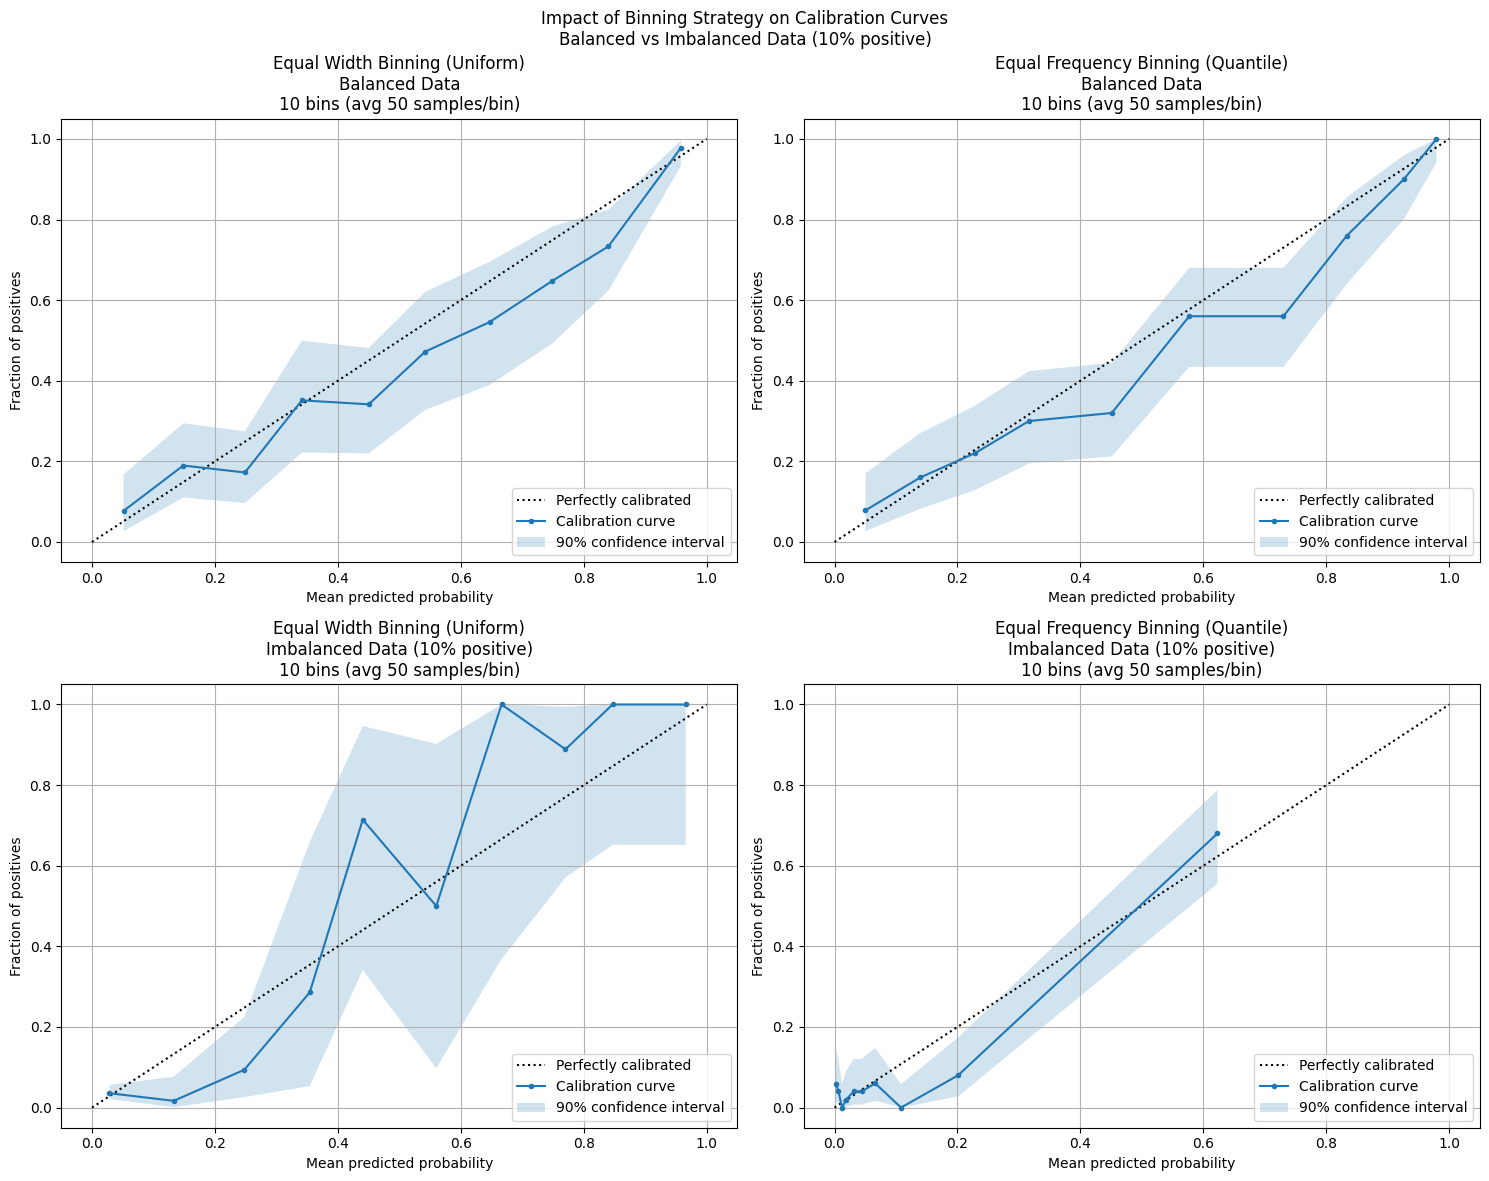

In [4]:
# Compare binning strategies
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(
    "Impact of Binning Strategy on Calibration Curves\n"
    "Balanced vs Imbalanced Data (10% positive)"
)

# Equal width binning on balanced data
cal_uniform = CalibrationCurve(
    binning_strategy="uniform",
    n_bins=10,
    confidence_method="clopper_pearson",
)
cal_uniform.fit(y_balanced_test, lr_balanced_probs)
cal_uniform.plot(ax=axes[0, 0])
axes[0, 0].set_title(
    "Equal Width Binning (Uniform)\nBalanced Data\n"
    f"10 bins (avg {len(y_balanced_test) // 10:.0f} samples/bin)"
)

# Equal frequency binning on balanced data
cal_quantile = CalibrationCurve(
    binning_strategy="quantile",
    n_bins=10,
    confidence_method="clopper_pearson",
)
cal_quantile.fit(y_balanced_test, lr_balanced_probs)
cal_quantile.plot(ax=axes[0, 1])
axes[0, 1].set_title(
    "Equal Frequency Binning (Quantile)\nBalanced Data\n"
    f"10 bins (avg {len(y_balanced_test) // 10:.0f} samples/bin)"
)

# Compare on imbalanced data
cal_uniform_imbal = CalibrationCurve(
    binning_strategy="uniform",
    n_bins=10,
    confidence_method="clopper_pearson",
)
cal_uniform_imbal.fit(y_imbal_test, lr_imbal_probs)
cal_uniform_imbal.plot(ax=axes[1, 0])
axes[1, 0].set_title(
    "Equal Width Binning (Uniform)\nImbalanced Data (10% positive)\n"
    f"10 bins (avg {len(y_imbal_test) // 10:.0f} samples/bin)"
)

# Equal frequency binning on imbalanced data
cal_quantile_imbal = CalibrationCurve(
    binning_strategy="quantile",
    n_bins=10,
    confidence_method="clopper_pearson",
)
cal_quantile_imbal.fit(y_imbal_test, lr_imbal_probs)
cal_quantile_imbal.plot(ax=axes[1, 1])
axes[1, 1].set_title(
    "Equal Frequency Binning (Quantile)\nImbalanced Data (10% positive)\n"
    f"10 bins (avg {len(y_imbal_test) // 10:.0f} samples/bin)"
)

plt.tight_layout()

### Analysis of Binning Strategy Impact

The quantile strategy refuses to draw points in regions with few data points,
which can lead to empty or sparse bins while the uniform strategy can create
bins with no or very few samples resulting in very large uncertainty intervals
for those regions.

With imbalanced data, the uniform strategy can lead to bins with very few
samples, as a result the uncertainty intervals may be very large to be
informative.

The quantile strategy ensures balanced bin sizes, leading to more uniform
uncertainty throughout the curve, even when predictions are not uniformly
distributed which is often the case when classes are imbalanced.

- Equal Width (Uniform):
  - Pros: Easy to understand, consistent bin widths
  - Cons: Can have empty or sparse bins with large uncertainties

- Equal Frequency (Quantile):
  - Pros: Ensures balanced bin sizes, leading to more uniform uncertainty
  - Cons: Variable bin widths and truncated curves can be surprising

Let's analyze different binning strategies and their interaction with the
minimum samples per bin parameter:

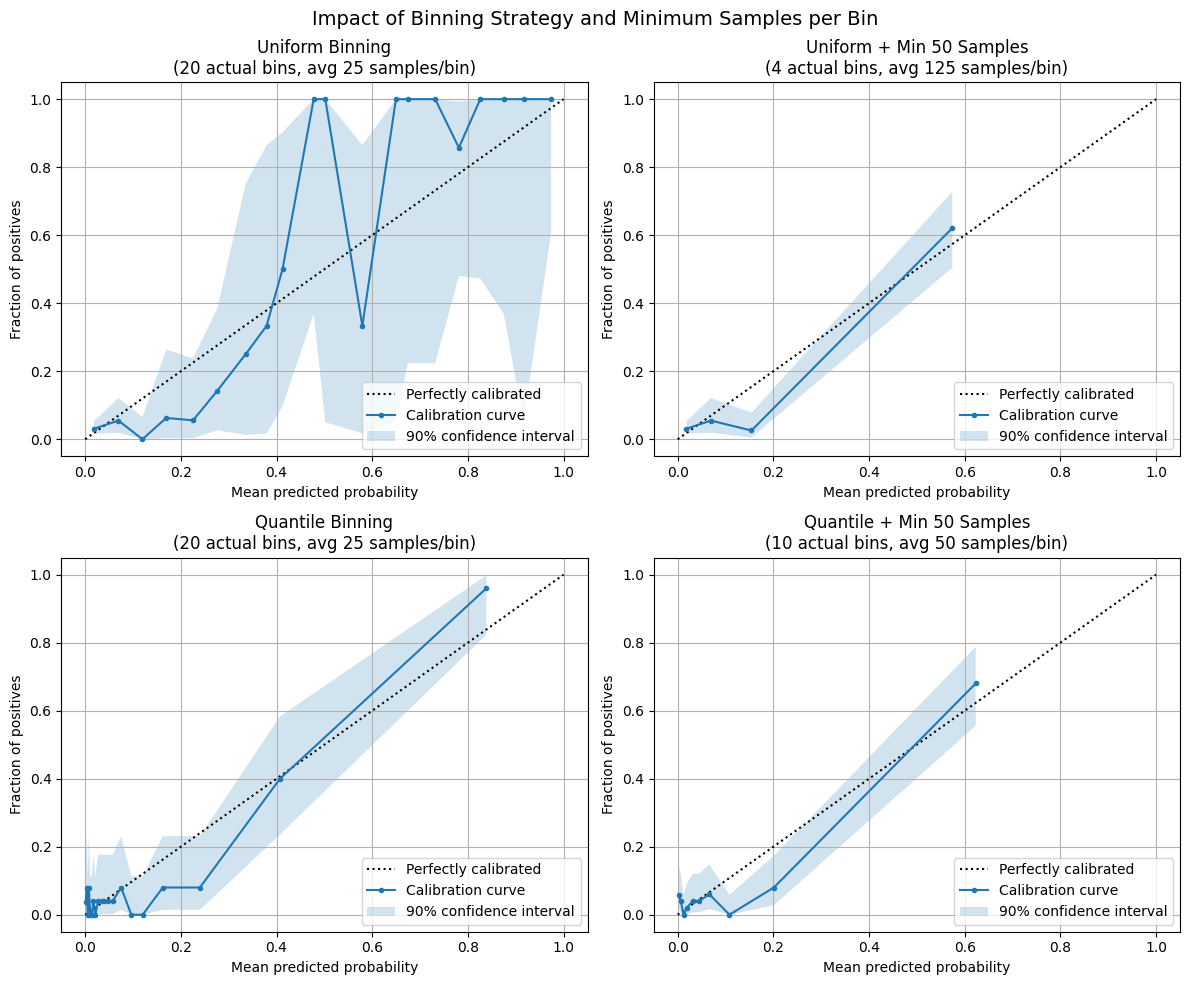

In [5]:
# Create plots to compare binning strategies and min_samples_per_bins settings
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Impact of Binning Strategy and Minimum Samples per Bin", fontsize=14)

# Plot settings to compare
settings = [
    {"strategy": "uniform", "min_samples": None, "title": "Uniform Binning"},
    {"strategy": "uniform", "min_samples": 50, "title": "Uniform + Min 50 Samples"},
    {"strategy": "quantile", "min_samples": None, "title": "Quantile Binning"},
    {"strategy": "quantile", "min_samples": 50, "title": "Quantile + Min 50 Samples"},
]

for ax, setting in zip(axes.flat, settings):
    cal = CalibrationCurve(
        binning_strategy=setting["strategy"],
        n_bins=20,  # Use more bins to better see the effect
        min_samples_per_bins=setting["min_samples"],
        confidence_method="clopper_pearson",
    )
    cal.fit(y_imbal_test, lr_imbal_probs)
    cal.plot(ax=ax)
    
    # Add actual number of bins used
    n_actual_bins = len(cal._bin_edges) - 1
    avg_samples = len(y_imbal_test) / n_actual_bins
    ax.set_title(
        f"{setting['title']}\n"
        f"({n_actual_bins} actual bins, avg {avg_samples:.0f} samples/bin)"
    )

plt.tight_layout()
plt.show()

Key observations about binning strategies and minimum samples per bin:

1. **Uniform Binning**:
   - Without minimum samples: Shows very wide confidence intervals in sparse
     regions
   - With minimum samples: Automatically merges sparse bins, leading to more
     stable estimates but variable bin widths

2. **Quantile Binning**:
   - Without minimum samples: Naturally avoids very sparse bins but can still
     have some bins with few samples
   - With minimum samples: Further reduces variance in uncertainty estimates by
     ensuring sufficient samples in each bin

3. **Impact of Minimum Samples**:
   - Reduces the number of bins in sparse regions
   - Makes uncertainty estimates more reliable by ensuring sufficient data
   - Can lead to variable bin widths even with uniform binning
   - Most impactful with uniform binning in imbalanced datasets

4. **Recommendations**:
   - For balanced data: Any strategy works well, min_samples optional
   - For imbalanced data:
     - Use quantile binning OR
     - Use uniform binning with min_samples_per_bins to prevent unreliable
       estimates
   - Rule of thumb: min_samples_per_bins should be at least 20-50 for reliable
     uncertainty estimates

## Bin Count Impact Analysis

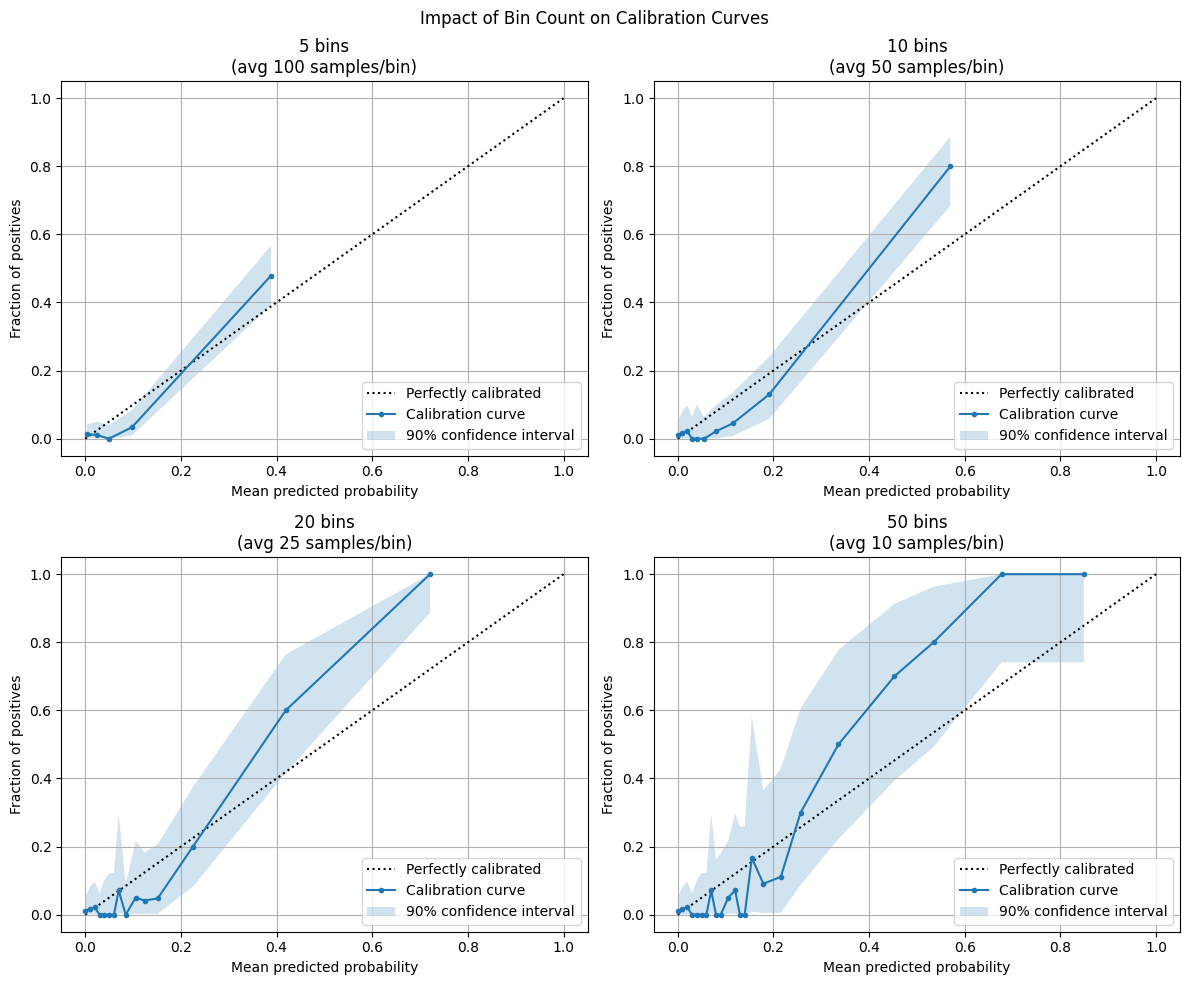

In [6]:
# Generate a single large dataset
n_samples_total = 3000
X_full, y_full = make_classification(
    n_samples=n_samples_total,
    n_features=20,
    n_informative=10,
    n_redundant=10,
    class_sep=0.8,
    random_state=42,
    weights=[0.9, 0.1],  # Exactly 10% positive samples
)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.5, random_state=42
)

# Train the model once on the training data
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get predictions for all test samples
test_probs = model.predict_proba(X_test)[:, 1]

# Now study different bin counts using the same 500 test samples
n_test_samples = 500
test_indices = np.random.RandomState(100).choice(
    len(y_test), size=n_test_samples, replace=False
)

# Use the same test samples for each bin count
y_test_subset = y_test[test_indices]
probs_subset = test_probs[test_indices]

n_bins_list = [5, 10, 20, 50]  # Extreme range of bin counts
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Impact of Bin Count on Calibration Curves")

for i, n_bins in enumerate(n_bins_list):
    row = i // 2
    col = i % 2
    
    cal = CalibrationCurve(
        binning_strategy="quantile",
        n_bins=n_bins,
        confidence_method="clopper_pearson",
    )
    cal.fit(y_test_subset, probs_subset)
    cal.plot(ax=axes[row, col])
    
    avg_samples = len(y_test_subset) / n_bins
    axes[row, col].set_title(
        f"{n_bins} bins\n"
        f"(avg {avg_samples:.0f} samples/bin)"
    )

plt.tight_layout()

### Analysis of Bin Count Impact

- Fewer bins (5-10):
  - Smoother curves
  - Wider confidence intervals
  - May miss important calibration details

- More bins (20-50):
  - More detailed calibration assessment
  - Narrower confidence intervals
  - May be noisier, especially with limited data

The choice of bin count depends on:
1. Dataset size (more data allows more bins)
2. Need for detail vs. smoothness
3. Computational budget (more bins = more computation)

## Uncertainty Estimation Methods

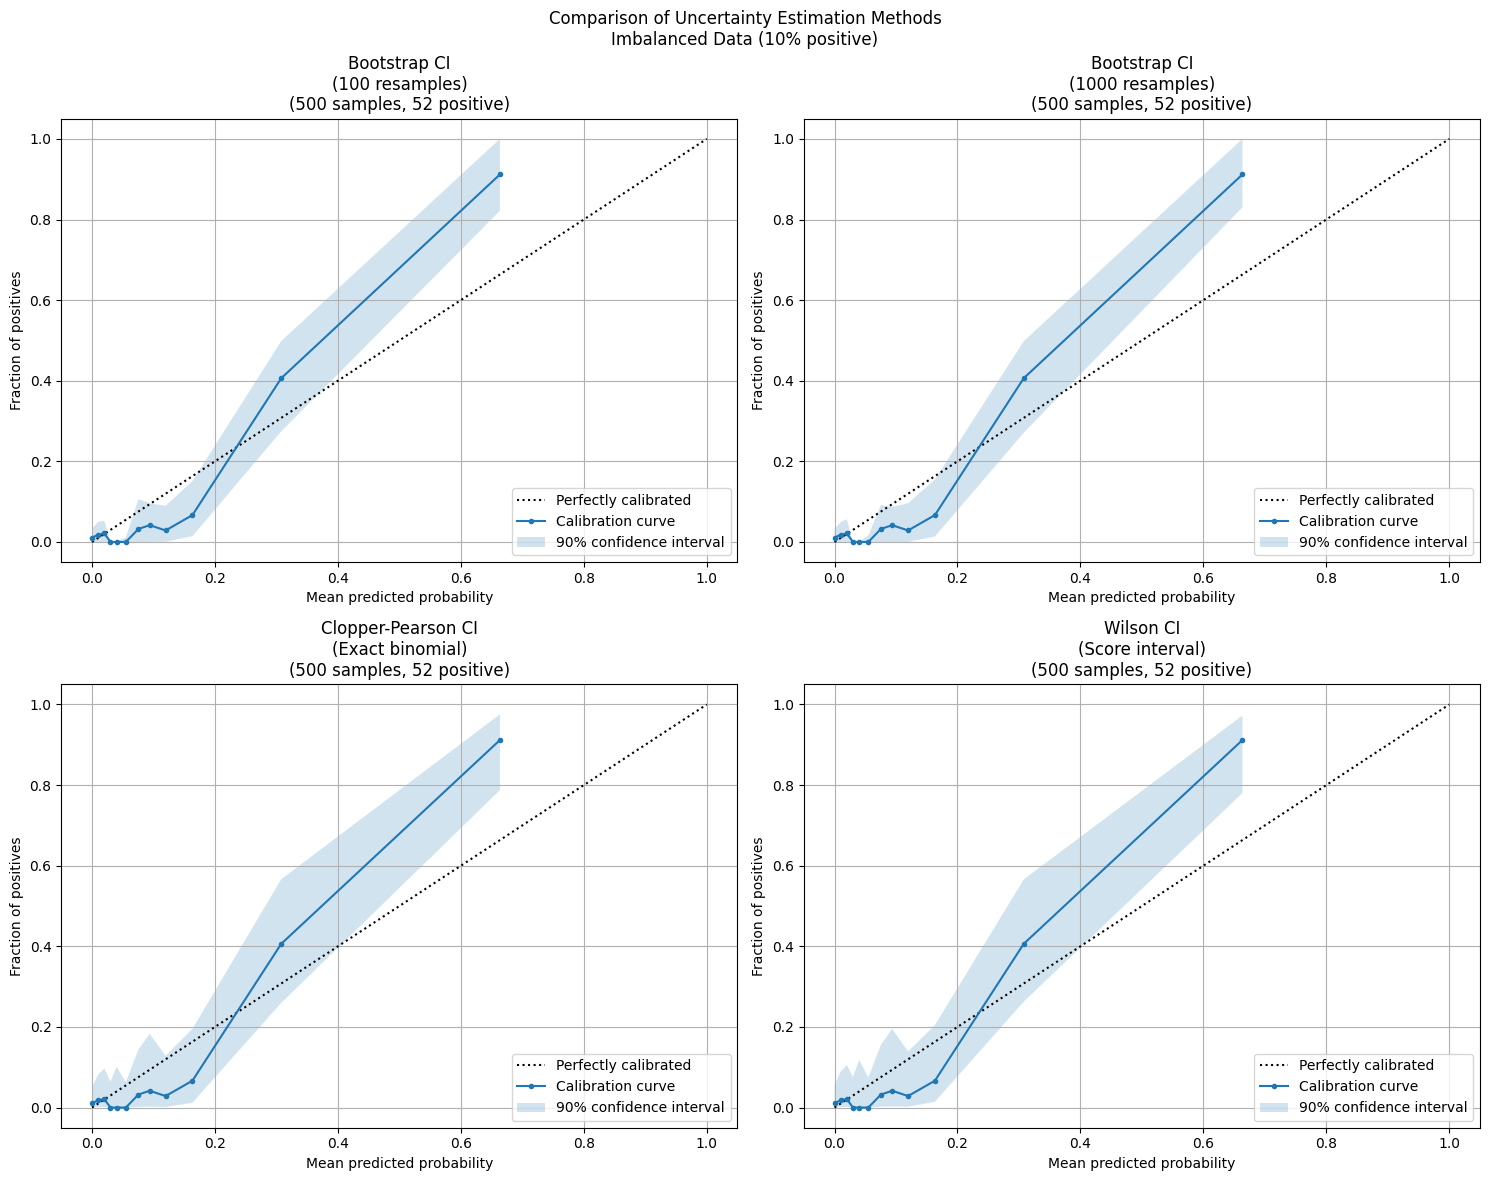

In [7]:
# Compare uncertainty estimation methods
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(
    "Comparison of Uncertainty Estimation Methods\nImbalanced Data (10% positive)"
)

n_bins = 15

# Bootstrap confidence intervals (100 resamples)
cal_bootstrap_100 = CalibrationCurve(
    binning_strategy="quantile",
    n_bins=n_bins,
    confidence_method="bootstrap",
    n_bootstrap=100,
    random_state=42,
)
cal_bootstrap_100.fit(y_test_subset, probs_subset)
cal_bootstrap_100.plot(ax=axes[0, 0])
axes[0, 0].set_title(
    "Bootstrap CI\n"
    "(100 resamples)\n"
    f"({n_test_samples} samples, {y_test_subset.sum():.0f} positive)"
)

# Bootstrap confidence intervals (1000 resamples)
cal_bootstrap_1000 = CalibrationCurve(
    binning_strategy="quantile",
    n_bins=n_bins,
    confidence_method="bootstrap",
    n_bootstrap=1000,
    random_state=42,
)
cal_bootstrap_1000.fit(y_test_subset, probs_subset)
cal_bootstrap_1000.plot(ax=axes[0, 1])
axes[0, 1].set_title(
    "Bootstrap CI\n"
    "(1000 resamples)\n"
    f"({n_test_samples} samples, {y_test_subset.sum():.0f} positive)"
)

# Clopper-Pearson intervals
cal_clopper = CalibrationCurve(
    binning_strategy="quantile", n_bins=n_bins, confidence_method="clopper_pearson"
)
cal_clopper.fit(y_test_subset, probs_subset)
cal_clopper.plot(ax=axes[1, 0])
axes[1, 0].set_title(
    "Clopper-Pearson CI\n"
    "(Exact binomial)\n"
    f"({n_test_samples} samples, {y_test_subset.sum():.0f} positive)"
)

# Wilson intervals
cal_wilson = CalibrationCurve(
    binning_strategy="quantile", n_bins=n_bins, confidence_method="wilson_cc"
)
cal_wilson.fit(y_test_subset, probs_subset)
cal_wilson.plot(ax=axes[1, 1])
axes[1, 1].set_title(
    "Wilson CI\n"
    "(Score interval)\n"
    f"({n_test_samples} samples, {y_test_subset.sum():.0f} positive)"
)

plt.tight_layout()

### Analysis of Uncertainty Estimation Methods

All methods lead to qualitatively similar results on this dataset, with some
method-specific characteristics:

- Bootstrap (100 vs 1000 resamples):
  - Both settings yield very similar confidence bands
  - Using 1000 resamples instead of 100 appears to add little value
  - Main limitation: can produce collapsed uncertainty estimates (zero width)
    in bins where all samples belong to the same class
  - This is particularly visible in regions with predicted probabilities close
    to 0

- Clopper-Pearson and Wilson-CC:
  - Both methods show similar characteristics
  - Both are similarly conservative in their uncertainty estimates
  - Wilson-CC (with continuity correction) behaves more like Clopper-Pearson
    than the regular Wilson score interval would
  - Note that empty bins are removed by default, otherwise would would get large
    uncertainty sparks

- Comparative Analysis:
  - All methods show increased uncertainty in regions with sparse data (p > 0.6)
  - The analytical methods (Clopper-Pearson and Wilson-CC) guarantee proper
    coverage but may be conservative
  - Bootstrap can be problematic with very few samples due to potential
    collapse of uncertainty estimates

- Recommendations:
  - For speed: Bootstrap with 100 resamples is sufficient
  - For guaranteed coverage: Either Clopper-Pearson or Wilson-CC

## Summary of Findings and Recommendations

1. **Binning Strategy Impact**:
   - Quantile binning ensures balanced bin sizes, recommended for imbalanced
     data
   - Uniform binning can lead to empty or sparse bins, making uncertainty
     estimates very large (or unreliable with the bootstrap)
   - The choice of binning strategy is often more impactful than the choice of
     uncertainty method

2. **Number of Bins**:
   - Fewer bins (5-10) provide smoother curves but may miss calibration details
   - More bins (20-50) show more detail but require sufficient samples per bin
   - Rule of thumb: aim for at least 5-10 samples of the minority class per bin
   - With imbalanced data, prefer fewer bins to ensure reliable uncertainty
     estimates

3. **Uncertainty Estimation Methods**:
   - All methods (Bootstrap, Clopper-Pearson, Wilson-CC) give similar results
   - Bootstrap with 100 resamples is sufficient; more resamples add little value
   - Both Clopper-Pearson and Wilson-CC provide similar, conservative coverage
   - Bootstrap can produce collapsed intervals with homogeneous bins

4. **Practical Recommendations**:
   - For speed: Use Bootstrap with 100 resamples
   - For guaranteed coverage: use Clopper-Pearson or Wilson-CC
   - Always report sample counts and class distribution alongside calibration
     curves